In [1]:
import zipfile
import os
import pandas as pd

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month #cria uma nova coluna com mês
            df['ano'] = df['data_base'].dt.year
            #Filtros:
            df = df[df['mes'] == 4] #trocar para o ano que você quer filtrar
            df = df[df['modalidade'] == "PJ - Capital de giro"]
            df['porte'] = df['porte'].str.replace(' ','')
            filtro1 = df['porte'] == "PJ-Micro"
            filtro2 = df['porte'] == "PJ-Pequeno"
            df = df.loc[filtro1 | filtro2]
            df = df[['data_base', 'modalidade', 'porte', 'a_vencer_ate_90_dias','a_vencer_de_91_ate_360_dias']]
            #Nova coluna para endividamento de curto prazo
            df['curto_prazo'] = df['a_vencer_ate_90_dias'] + df['a_vencer_de_91_ate_360_dias']
            df = df.drop(columns = ['a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias'], axis = 1)
            df['data_base'] = df['data_base'].dt.strftime('%Y-%m')
            #Agrupamentos para análise
            df = df.groupby(['data_base','modalidade','porte'])['curto_prazo'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [6]:
df_total.to_csv("analise_pj_curtoprazo.csv")

In [23]:
df_total.columns

Index(['data_base', 'modalidade', 'porte', 'curto_prazo'], dtype='object')

In [44]:
df_total.head(3)

,data_base,modalidade,porte,curto_prazo
0,2013-04,PJ - Capital de giro,PJ-Micro,2.114679e+10
1,2013-04,PJ - Capital de giro,PJ-Pequeno,3.281637e+10
0,2014-04,PJ - Capital de giro,PJ-Micro,2.140714e+10


In [10]:
import plotly.express as px

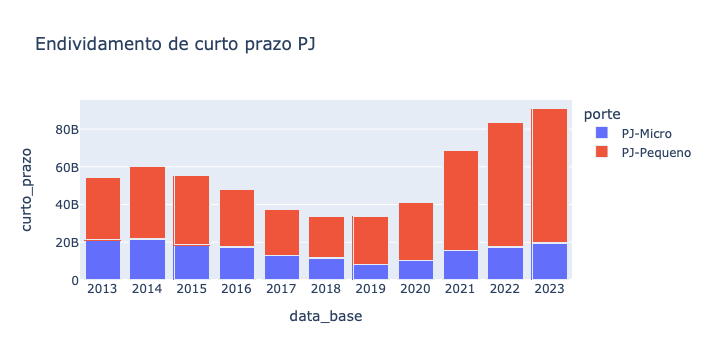

In [45]:
fig = px.bar(df_total, 
             x='data_base', 
             y='curto_prazo',
             title='Endividamento de curto prazo PJ',
             color='porte',
            barmode = 'stack') 

fig.update_xaxes(tickvals=df_com_coluna_total.index,
                tickformat="%Y")

fig.show()

In [25]:
df_com_coluna_total = df_total.pivot(index = 'data_base',
                                     columns = 'porte',
                                     values = 'curto_prazo')

In [29]:
df_com_coluna_total.head(3)

porte,PJ-Micro,PJ-Pequeno,total
data_base,,,
2013-04,2.114679e+10,3.281637e+10,5.396316e+10
2014-04,2.140714e+10,3.841721e+10,5.982435e+10
2015-04,1.846114e+10,3.667297e+10,5.513412e+10


In [28]:
df_com_coluna_total['total'] = df_com_coluna_total['PJ-Micro'] + df_com_coluna_total['PJ-Pequeno']
df_com_coluna_total.head(3)

porte,PJ-Micro,PJ-Pequeno,total
data_base,,,
2013-04,2.114679e+10,3.281637e+10,5.396316e+10
2014-04,2.140714e+10,3.841721e+10,5.982435e+10
2015-04,1.846114e+10,3.667297e+10,5.513412e+10


In [33]:
df_com_coluna_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 2013-04 to 2023-04
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PJ-Micro    11 non-null     float64
 1   PJ-Pequeno  11 non-null     float64
 2   total       11 non-null     float64
dtypes: float64(3)
memory usage: 352.0+ bytes


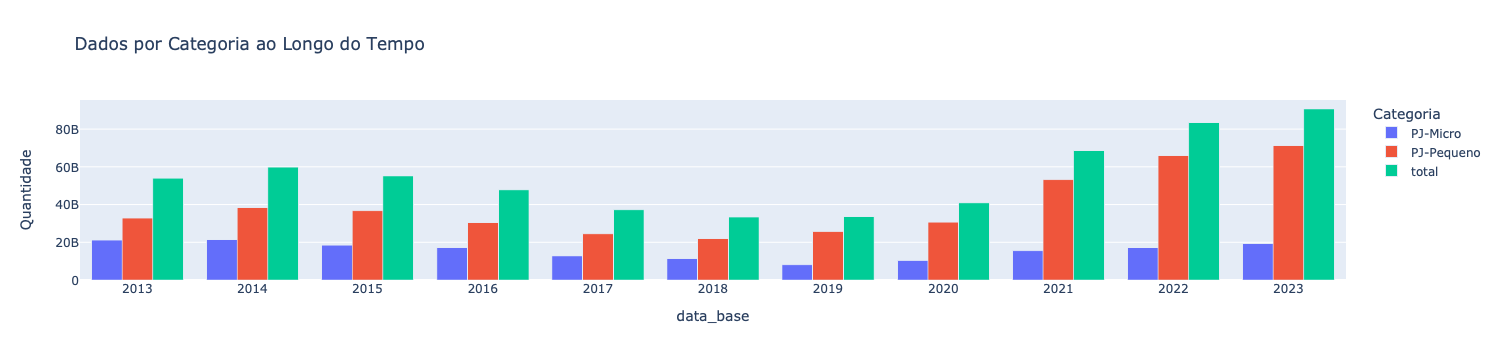

In [42]:
fig = px.bar(df_com_coluna_total, 
             x=df_com_coluna_total.index, 
             y=["PJ-Micro", "PJ-Pequeno","total"],
             title='Dados por Categoria ao Longo do Tempo',
             labels={'value': 'Quantidade', 'variable': 'Categoria', 'index': 'Data'},
             barmode='group')

fig.update_xaxes(tickvals=df_com_coluna_total.index,
                tickformat="%Y")

fig.show()